# Tutorial: Computer CPU Evolution Analysis
CMU 15688 Spring 2021


### Setting up environment
https://drive.google.com/file/d/1ahobYKS66mL53KQhhMg8KoziKq74lToU/view?usp=sharing

In [274]:
import requests
import csv
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
import re
import matplotlib.pyplot as plt

In [15]:
!wget -q --show-progress 'https://drive.google.com/uc?export=download&id=1ahobYKS66mL53KQhhMg8KoziKq74lToU' -O Intel_CPUs.csv

Intel_CPUs.csv      100%[===================>] 557.62K  --.-KB/s    in 0.1s    


In [356]:
csv_file_name = 'Intel_CPUs.csv'
df = pd.read_csv(csv_file_name, header=0, sep=',', quotechar='"', dtype=str, keep_default_na=True)

### Preprocess

In [357]:
def search_string_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_process_node = re.compile('(\d+\.?\d*)')
    result = regex_process_node.search(input_value)
    if result == None:
        return float('nan')
    return float(result.group())

def search_freq_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_freq = re.compile('(\d+\.?\d*)\s?([MG]Hz)')
    result = regex_freq.search(input_value)
    if result == None:
        return float('nan')
    if result.group(2) == 'MHz':
        return float(result.group(1)) / 1000
    else:
        return float(result.group(1))

def launch_date_to_datetime(input_value):
    if pd.isna(input_value):
        return float('nan')
    # some data is in the format of 04'16, should be Q4'16
    # like E5-2699AV4, it was released in Oct 2016
    # interestingly this is in fact a typo on Intel's offical site
    if input_value[0] == '0':
        input_value = 'Q' + input_value[1:]
    input_value = input_value.replace(' ', '')
    return pd.to_datetime('-'.join(input_value.split("'")[::-1]))


In [354]:
print(search_string_to_float('512KB'))

# print(df.iloc[12]['Launch_Date'])

# print(df.iloc[12]['Launch_Date'].apply(lambda x: launch_date_to_datetime(x)))
# print(launch_date_to_datetime(df.iloc[12]['Launch_Date']))
# print(pd.isna(float('nan')))
# print(pd.to_datetime('15-Q1'))
print(search_freq_to_float('800 MHz'))

512.0
0.8


In [358]:
df.dropna(subset=['Processor_Number', 'Launch_Date'], inplace=True)
df = df[~(df.Vertical_Segment == 'Server')]
df = df[~(df.Vertical_Segment == 'Embedded')]
df = df[~(df.Processor_Number.apply(lambda x: x.isnumeric()))]
drop_columns = [
    'Bus_Speed',
    'Embedded_Options_Available',
    'Processor_Graphics_', 
    'Graphics_Max_Dynamic_Frequency',
    'Graphics_Video_Max_Memory',
    'Graphics_Output',
    'Max_Resolution_HDMI',
    'Max_Resolution_DP',
    'Max_Resolution_eDP_Integrated_Flat_Panel',
    'OpenGL_Support',
    'PCI_Express_Revision',
    'PCI_Express_Configurations_',
    'Intel_Virtualization_Technology_VTx_',
    'Intel_64_',
    'Instruction_Set_Extensions',
    'Idle_States',
    'Thermal_Monitoring_Technologies',
    'Secure_Key',
    'Execute_Disable_Bit'    
]
df.drop(columns=drop_columns, inplace=True, errors='ignore')
df['Launch_Date'] = df['Launch_Date'].apply(lambda x: launch_date_to_datetime(x))
search_string_to_float_columns = [
    'Lithography',
    'Recommended_Customer_Price',
    'nb_of_Cores',
    'nb_of_Threads',
    'TDP',
    'Instruction_Set'
]
search_freq_to_float_columns = [
    'Processor_Base_Frequency',
    'Max_Turbo_Frequency'
]
for column_name in search_string_to_float_columns:
    df[column_name] = df[column_name].apply(lambda x: search_string_to_float(x))  
for column_name in search_freq_to_float_columns:
    df[column_name] = df[column_name].apply(lambda x: search_freq_to_float(x))
    
df.reset_index(drop=True, inplace=True)
    
print('Done')
print(df.shape)


Done
(943, 26)


In [350]:
print(df['Processor_Base_Frequency'])

0      1.3
1      1.6
2      1.8
3      3.6
4      1.2
      ... 
938    1.1
939    1.1
940    1.2
941    2.0
942    3.1
Name: Processor_Base_Frequency, Length: 943, dtype: float64


### Scraping CPU performance scores

In [203]:
def form_geekbench_url(cpu_name):
    query_url = 'https://browser.geekbench.com/v5/cpu/search?q='
    query_url += cpu_name
    return query_url

def parse_num_result(input_string):
    # remove ',' in numerical result
    input_string = input_string.replace(',', '')
    regex_num_result = re.compile('(\d+)')
    # should be a list of all numerical values in the input_string
    num_result_list = regex_num_result.search(input_string)
    return int(num_result_list.group())

def get_geekbench_score(cpu_series, cpu_name):
    if pd.isna(cpu_name):
        return tuple((float('nan'), float('nan')))
#     if cpu_name.isnumeric() and cpu_series.split()[0] == 'Legacy':
#         return tuple((float('nan'), float('nan')))
    query_url = form_geekbench_url(cpu_name)
    geekbench_response = requests.get(query_url)
    root = BeautifulSoup(geekbench_response.content, 'html.parser')
    
    num_result = parse_num_result(root.find('small').get_text())
    if num_result == 0:
        return tuple((float('nan'), float('nan')))
    # if less than five results, take the 1st one
    # else, take the average of first 5 results
    if num_result < 5:
        single_score_text = root.find_all('span', class_='list-col-subtitle-score', text='\nSingle-Core Score\n')[0]
        single_score_value = single_score_text.find_next_sibling('span', class_='list-col-text-score')
        multi_score_text = root.find_all('span', class_='list-col-subtitle-score', text='\nMulti-Core Score\n')[0]
        multi_score_value = multi_score_text.find_next_sibling('span', class_='list-col-text-score')
        return tuple((float(single_score_value.get_text()), float(multi_score_value.get_text())))
    else:
        total_single_score = 0.0
        total_multi_score = 0.0
        for span in root.find_all('span', class_='list-col-subtitle-score', text='\nSingle-Core Score\n')[:5]:
            single_score_value = span.find_next_sibling('span', class_='list-col-text-score')
            total_single_score += float(single_score_value.get_text())
        for span in root.find_all('span', class_='list-col-subtitle-score', text='\nMulti-Core Score\n')[:5]:
            multi_score_value = span.find_next_sibling('span', class_='list-col-text-score')
            total_multi_score += float(multi_score_value.get_text())
        return tuple((total_single_score / 5, total_multi_score / 5))

In [204]:
print(get_geekbench_score('Intel® Pentium® Processor J Series', 'J2850'))
print(get_geekbench_score('8th Generation Intel® Core™ i7 Processors', 'i7-8550U'))
print(get_geekbench_score('Legacy xxx', '1234'))

(225.0, 799.0)
(1047.8, 3546.2)
(nan, nan)


In [ ]:
def scrap_geekbench(df):
    df_scrape = df.apply(lambda x: get_geekbench_score(x.Product_Collection, x.Processor_Number), axis=1)
    df_geekbench_scores = pd.DataFrame()
    df_geekbench_scores['Geekbench_Single'] = df_scrape.apply(lambda x: x[0])
    df_geekbench_scores['Geekbench_Multi'] = df_scrape.apply(lambda x: x[1])
    return df_geekbench_scores
df_geekbench_scores = scrap_geekbench(df)

In [359]:
csv_file_name = 'Intel_CPUs_only_geekbench_score.csv'
df_geekbench_scores = pd.read_csv(csv_file_name, header=0, sep=',', quotechar='"', dtype=str, keep_default_na=True)

In [360]:
df_with_score = df.join(df_geekbench_scores)
df_with_score.dropna(subset=['Geekbench_Single', 'Geekbench_Multi'], inplace=True)

In [361]:
df_with_score.to_csv('Intel_CPUs_with_score.csv', encoding='utf-8', index=False)

### Moore's Law

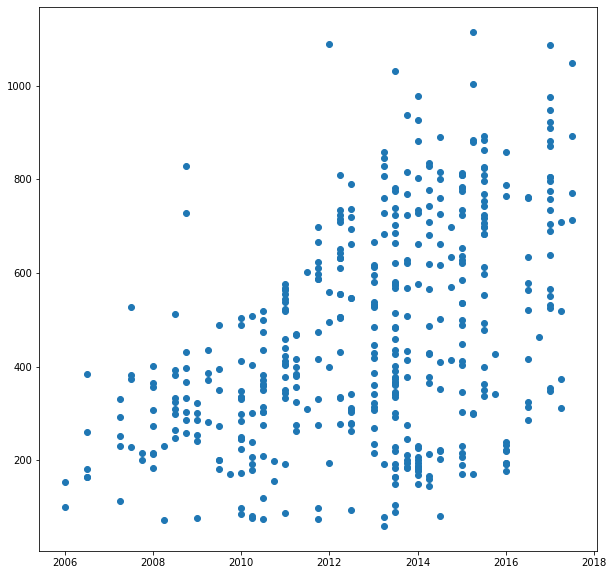

In [432]:
df_desktop = df_with_score[df_with_score.Vertical_Segment == 'Desktop']
df_mobile = df_with_score[df_with_score.Vertical_Segment == 'Mobile']

# df_Core_desktop = df_desktop[df_desktop.Product_Collection.str.contains('Core', regex=False)]
# df_Core_desktop = df_Core_desktop[~(df_Core_desktop.Processor_Number.str.contains('T', regex=False))]
# df_Core_desktop = df_Core_desktop[~(df_Core_desktop.Processor_Number.str.contains('S', regex=False))]

# df_Core_desktop = df_Core_desktop[~(df_Core_desktop.Processor_Number.str.contains('R', regex=False))]

# df_Core_desktop = df_Core_desktop[~(df_Core_desktop.Processor_Number.str.contains('i3', regex=False))]
df_mobile.to_csv('core.csv', encoding='utf-8', index=False)
launch_time = df_mobile['Launch_Date'].values
single_core_perf = df_mobile['Geekbench_Single'].apply(lambda x: float(x)).values
multi_core_perf = df_mobile['Geekbench_Multi'].apply(lambda x: float(x)).values
# li = df_mobile['T'].apply(lambda x: float(x)).values


plt.figure(figsize=(10,10))

# plt.xticks(np.arange(2006,2018,step=1))
# plt.yticks(np.arange(0,16000,step=1000))
plt.scatter(launch_time, single_core_perf)
plt.show()